In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [254]:
data = pd.read_csv("../data/super_cleaned_data.csv")
data.shape

(35705, 2)

In [283]:
X = data.OriginalTweet
y = pd.Categorical(data.Sentiment)

In [284]:
y.unique()

['Positive', 'Extremely Negative', 'Negative', 'Neutral', 'Extremely Positive']
Categories (5, object): ['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']

In [285]:
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)
X_train = X_train.astype(str)
X_val = X_val.astype(str)
X_test = X_test.astype(str)
print(f"Shape of X_train is: {X_train.shape}, X_val is: {X_val.shape} and X_test is: {X_test.shape}")
print(f"Shape of y_train is: {y_train.shape}, y_val is: {y_val.shape} and y_test is: {y_test.shape}")

Shape of X_train is: (28564,), X_val is: (3570,) and X_test is: (3571,)
Shape of y_train is: (28564,), y_val is: (3570,) and y_test is: (3571,)


In [286]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch

MAX_WORDS = 30000
tokenizer = Tokenizer(num_words=MAX_WORDS, char_level=False, split=' ')
tokenizer.fit_on_texts(X_train)

In [287]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [288]:
seq_lens = [len(x) for x in X_train]
print(f"Maximum length of sequence is: {max(seq_lens)}")
print(f"Mean length of the sequence is at word level: {np.mean(seq_lens):.4f}")

Maximum length of sequence is: 41
Mean length of the sequence is at word level: 17.6466


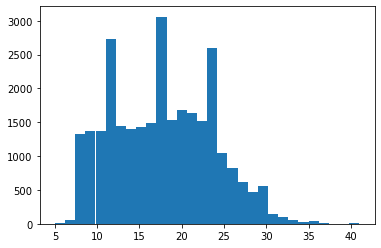

In [289]:
plt.hist(seq_lens, bins=30);

In [290]:
MAX_SEQUENCE_LENGTH = 40

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32')
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, dtype='float32')
print(f"Shape of X_train is: {X_train.shape}, X_val is: {X_val.shape} and X_test is: {X_test.shape}")

Shape of X_train is: (28564, 40), X_val is: (3570, 40) and X_test is: (3571, 40)


In [294]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

labelEncoder = LabelEncoder()
labelEncoder.fit(y_train)


y_train = labelEncoder.transform(y_train)
y_test = labelEncoder.transform(y_test)
y_val = labelEncoder.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


print(f"Shape of y_train is: {y_train.shape}, y_val is: {y_val.shape} and y_test is: {y_test.shape}")

Shape of y_train is: (28564, 5), y_val is: (3570, 5) and y_test is: (3571, 5)


## Basic Neural network

In [263]:
X_train_basic = (X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train))
X_val_basic = (X_val - np.min(X_val))/(np.max(X_val) - np.min(X_val))
X_test_basic = (X_test - np.min(X_test))/(np.max(X_test) - np.min(X_test))

In [239]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [268]:
test_model = Sequential()
test_model.add(Dense(2048, activation='tanh', input_shape=(X_train.shape[1],)))
test_model.add(Dense(1024, activation='tanh'))
test_model.add(Dense(1024, activation='relu'))
test_model.add(Dense(512, activation='relu'))
test_model.add(Dense(256, activation='relu'))
test_model.add(Dense(5, activation='softmax'))

# uncomment the line below to compile the model

# test_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [269]:
test_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 2048)              83968     
                                                                 
 dense_88 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_89 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_90 (Dense)            (None, 512)               524800    
                                                                 
 dense_91 (Dense)            (None, 256)               131328    
                                                                 
 dense_92 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 3889157 (14.84 MB)
Trainable params: 38

In [ ]:
# uncomment the line below to run the model

# test_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=True)

In [271]:
# uncomment the line below to evaluate the model

# test_model.evaluate(X_test, y_test)

112/112 [==============================] - 1s 5ms/step - loss: 1.5420 - accuracy: 0.2896


[1.5419923067092896, 0.28955474495887756]

This model is not performing very well. It starts getting overfit when the network is expanded horizontally and underfits if the network is given the depth. I could'nt understand the issue in this.

## Using the embedding layer in Neural network

In [253]:
from tensorflow.keras.layers import Dense, Embedding, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

In [301]:
EMBEDDING_DIM = 20
N_CLASSES = 5

embedding_model = Sequential()
embedding_model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32'))
embedding_model.add(Embedding(MAX_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
embedding_model.add(GlobalAveragePooling1D())
embedding_model.add(Dense(128, activation='relu'))
embedding_model.add(Dense(16, activation='relu'))
embedding_model.add(Dense(N_CLASSES, activation='softmax'))
embedding_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [302]:
embedding_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 40, 20)            600000    
                                                                 
 global_average_pooling1d_8  (None, 20)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_101 (Dense)           (None, 128)               2688      
                                                                 
 dense_102 (Dense)           (None, 16)                2064      
                                                                 
 dense_103 (Dense)           (None, 5)                 85        
                                                                 
Total params: 604837 (2.31 MB)
Trainable params: 604837 (2.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [303]:
embedding_model.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_val, y_val), verbose=False)

In [304]:
embedding_model.evaluate(X_test, y_test)

112/112 [==============================] - 0s 1ms/step - loss: 1.1235 - acc: 0.6718


[1.1235387325286865, 0.6718006134033203]

The embedding model gave good accuracy when trained over a subset of 5000 training sample. Now we will run it for complete training data.

1. When the dimensions were set to 20, there was overfitting just after 6 epochs. The test accuracy achieved was 62%. Possible reasons can be that the dimension space is too large.
2. With an embedding size of 50, we did prevented overfitting and stopped after 6 epochs (elbow noticed). The accuracy over test data is 64%. We can further reduce the dimensions.
3. With an embedding dimension of 20, we achieved an accuracy of 65.16% over the test data.
4. With an embedding dimension of 10, we achieved an accuracy of 64.91% over the test data.
5. A strange phenomena, if we add 2 dense layers after the pooling layer the accuracy over the test data jumps to 67.63%.
6. When adding 2 dense layers, first expanding the dimension (128) and then a 16 node layer, the accuracy over the test data is 68.75%.